In [2]:
!pip install -q -r requirements.txt

In [ ]:
# !pip uninstall -y opencv-python-headless
# !pip install opencv-python-headless==4.1.2.30

## Data Loading

In [ ]:
from os.path import join
import numpy as np 
import torch
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DATA_ROOT="../datas/2_Domain_Adaptation_dataset/"

MRI_root_dir=join(DATA_ROOT,"MRI","MRI_Label")
MRI_anno_file=join(DATA_ROOT,"MRI","annotations/MRI_Label/annotations.json")

CT_root_dir=join(DATA_ROOT,"CT")
CT_anno_file=join(DATA_ROOT,"CT","annotations/annotations.json")

In [ ]:
from dataloaders.ctmri_multiclass import CTMRI_MultiClassDataset
import albumentations as A
WIDTH, HEIGHT=256,256

class DivMax(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
    def apply(self, img, **params):
        img=img/np.max(img)
#         img[img<0.25]=0
#         img[img>0.65]=0
        return img
    
transform = A.Compose([
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
  A.Rotate((-30, 30), interpolation=0), 
  A.RandomContrast(limit=0.2, p=1),   
])

test_transform = A.Compose([           
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
])

In [4]:
ds_kwargs=dict(
    transform=transform,
    test_transform=test_transform,
    test_split=0.2
    )
MRI_ds=CTMRI_MultiClassDataset(MRI_anno_file,MRI_root_dir,**ds_kwargs)
CT_ds=CTMRI_MultiClassDataset(CT_anno_file,CT_root_dir,**ds_kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
import torch.utils.data as tud
ldr_kwargs=dict(
    batch_size=8,
    shuffle=True,
    pin_memory=False,
    num_workers=2
)
CT_loader=tud.DataLoader(CT_ds,**ldr_kwargs)
MRI_loader=tud.DataLoader(MRI_ds,**ldr_kwargs)

In [9]:
from dataloaders.ctmri_multiclass import occr_in_ds

MRI_occr=occr_in_ds(MRI_ds)
CT_occr=occr_in_ds(CT_ds)

BATCHSIZE= 3
(3, 256, 256, 3) 
 (3, 256, 256)


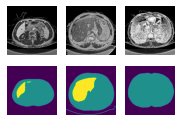

In [11]:
from utils.plotting import show_image_annot
CT_ds.training=True
x,y=next(iter(CT_loader))
show_image_annot(x.numpy().transpose(0,2,3,1),y.numpy(),showPics=3, vmax=CT_ds.n_cats)

In [8]:
set(y.flatten().numpy())

{0, 1, 2}

In [12]:
# from torch import nn

from models.backbone import UNet
from models.head import MetricLayer
from models.models import SegModel
backbone=UNet(decoder_chs=(512, 256, 128)).cuda()
latent_dims=128
head_ct=MetricLayer(n_in_features=latent_dims,n_out_features=1+CT_ds.n_cats).cuda()
model_ct=SegModel(backbone,head_ct,(WIDTH, HEIGHT)).cuda()

In [51]:
# from torchsummary import summary
# summary(backbone.encoder, (3, 224, 224))

In [27]:
def calc_acc(pred, y):
    correct=(pred.argmax(1)==y).flatten()
    return torch.sum(correct)/len(correct)
def one_batch(i_iter,log,sample_batched,model,criterion,optimizer):
    # Prep input
    x,y=[_.cuda() for _ in sample_batched]
    pred=model(x)
    loss = criterion(pred, y)
    if model.training:
        #Update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        acc=calc_acc(pred, y).item()
        if i_iter==0:
            log['acc'] = acc
        else:
            log['acc'] = (acc+log['acc']*i_iter)/(i_iter + 1)
    # Record
    loss_rec = loss.item()
    log['loss'] = (loss_rec+log['loss']*i_iter)/(i_iter + 1)
    return pred,loss

In [14]:
!mkdir snapshots

mkdir: cannot create directory ‘snapshots’: File exists


In [21]:
from losses.marginal import AddMarginLoss
w=1/torch.tensor(CT_occr,dtype=torch.float32).cuda()
criterion_ct = AddMarginLoss(ways=1+CT_ds.n_cats,s=3,m=0.4,weight=w)
optimizer_ct = torch.optim.SGD(model_ct.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# 
# scheduler = MultiStepLR(optimizer, milestones=[100, 200, 300], gamma=0.1)
# 

In [22]:
from tqdm import tqdm

EPOCH=100
model_ct.train()
best_loss=np.inf
PAITIENCE=5
count=0
try:
    for e in range(EPOCH):
        log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
        model_ct.train()
        CT_ds.training=True
        session=tqdm(enumerate(CT_loader))
        for i_iter, sample_batched in session:
            pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
            # print loss and take snapshots
            if (i_iter + 1) % 5 == 0:
                log['step']=i_iter+1
                session.set_postfix(log)
        # validate
        if (e + 1) % 2 == 0:
            log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
            model_ct.eval()
            CT_ds.training=False
            session=tqdm(enumerate(CT_loader))
            with torch.no_grad():
                for i_iter,sample_batched in session:
                    pred,loss=one_batch(i_iter,log,sample_batched,model_ct,criterion_ct,optimizer_ct)
                    if (i_iter + 1) % 5 == 0:
                        session.set_postfix(log)
            # early stop        
            if log["loss"]<best_loss:
                best_loss=log["loss"]
                torch.save(model.state_dict(), 'snapshots/unet_arc_best.pth')
            elif count<=PAITIENCE: count+=1
            else:
                count=0
                best_loss=np.inf
                break 
            
except KeyboardInterrupt:
    print("\nHuman Interrupted")
torch.save(model.state_dict(), 'snapshots/unet_arc_latest.pth')

288it [01:07,  4.27it/s, epoch=0, step=285, loss=0.258, acc=0.892]
288it [01:08,  4.22it/s, epoch=1, step=285, loss=0.0605, acc=0.948]
72it [00:07, 10.00it/s, epoch=1, step=val, loss=0.0435, acc=0.958]
288it [01:08,  4.20it/s, epoch=2, step=285, loss=0.0416, acc=0.957]
288it [01:08,  4.20it/s, epoch=3, step=285, loss=0.0328, acc=0.962]
72it [00:07,  9.87it/s, epoch=3, step=val, loss=0.0265, acc=0.968]
288it [01:08,  4.19it/s, epoch=4, step=285, loss=0.027, acc=0.967] 
288it [01:08,  4.19it/s, epoch=5, step=285, loss=0.0231, acc=0.97] 
72it [00:07,  9.84it/s, epoch=5, step=val, loss=0.02, acc=0.973]  
288it [01:08,  4.20it/s, epoch=6, step=285, loss=0.0207, acc=0.972]
10it [00:02,  3.51it/s, epoch=7, step=10, loss=0.0211, acc=0.971]


Human Interrupted


BATCHSIZE= 3
(3, 256, 256) 
 (3, 256, 256)


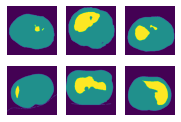

In [23]:
show_image_annot(pred.cpu().detach().argmax(1).numpy(),
                 sample_batched[1].cpu().detach().numpy(),
                 showPics=3, vmax=CT_ds.n_cats)

In [29]:
mri_head=MetricLayer(n_in_features=latent_dims,n_out_features=1+MRI_ds.n_cats).cuda()
model_mri=SegModel(backbone,mri_head,(WIDTH, HEIGHT)).cuda()
criterion_mri = AddMarginLoss(ways=1+MRI_ds.n_cats,s=3,m=0.4,weight=w)
optimizer_mri = torch.optim.SGD(model_mri.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [25]:
log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
model.eval()
MRI_ds.training=False
session=tqdm(enumerate(MRI_loader))
with torch.no_grad():
    for i_iter,sample_batched in session:
        pred,loss=one_batch(i_iter,log,sample_batched,model,criterion,optimizer)
        if (i_iter + 1) % 5 == 0:
            session.set_postfix(log)

0it [00:00, ?it/s]


RuntimeError: The size of tensor a (3) must match the size of tensor b (6) at non-singleton dimension 1